Packages implementing traditional statistics and machine learning for causal inference (such as EconML) are popular for their "Causal Forests" algorithm which gives interpretability to heterogeneous treatment effects.

In this notebook I attempt a neural network analog to Causal Forests for understanding heterogeneous treatment effects.

In [ ]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO, Predictive
from pyro.infer.autoguide import AutoDiagonalNormal
from pyro.optim import Adam
import matplotlib.pyplot as plt
import numpy as np

pyro.set_rng_seed(0)
pyro.clear_param_store()
device = torch.device("cpu")

In [2]:
# -----------------------------
# 1) Simulate data
# -----------------------------
def true_tau(X):
    x0 = torch.sigmoid(X[:, 0]) * 2.0
    x1 = (X[:, 1] ** 2) * 1.5
    x2 = torch.tanh(X[:, 2]) * (-1.0)
    return x0 + x1 + x2

def base_outcome(X):
    return 1.0 + 0.5 * X[:, 0] - 0.3 * X[:, 1] + 0.2 * X[:, 2]

N = 1000
D = 6
X = torch.randn(N, D)
logit = -0.2 + 0.8 * X[:, 0] - 0.5 * X[:, 1]
p = torch.sigmoid(logit)
treatment = torch.bernoulli(p).float()

tau_true = true_tau(X)
y0 = base_outcome(X) + torch.randn(N) * 0.5
y = y0 + tau_true * treatment
y = y + torch.randn(N) * 0.5

X_train = X.to(device)
t_train = treatment.to(device)
y_train = y.to(device)

In [3]:
# -----------------------------
# 2) Define additive subnets
# -----------------------------
class OneDSubNet(nn.Module):
    def __init__(self, hidden=16):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, hidden),
            nn.ReLU(),
            nn.Linear(hidden, 1)
        )
    def forward(self, x):
        if x.dim() == 1:
            x = x.unsqueeze(1)
        return self.net(x).squeeze(1)

class AdditiveCATEModel(nn.Module):
    def __init__(self, D, hidden=16):
        super().__init__()
        self.tau_subnets = nn.ModuleList([OneDSubNet(hidden) for _ in range(D)])
        self.base = nn.Sequential(nn.Linear(D, 32), nn.ReLU(), nn.Linear(32, 1))
    def forward(self, X, t):
        taus = [ subnet(X[:, i]) for i, subnet in enumerate(self.tau_subnets) ]
        tau = torch.stack(taus, dim=1).sum(dim=1)
        baseline = self.base(X).squeeze(1)
        y_mean = baseline + tau * t
        return y_mean, baseline, tau

det_model = AdditiveCATEModel(D, hidden=16)
det_model

AdditiveCATEModel(
  (tau_subnets): ModuleList(
    (0-5): 6 x OneDSubNet(
      (net): Sequential(
        (0): Linear(in_features=1, out_features=16, bias=True)
        (1): ReLU()
        (2): Linear(in_features=16, out_features=1, bias=True)
      )
    )
  )
  (base): Sequential(
    (0): Linear(in_features=6, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [4]:
# -----------------------------
# 3) Pyro model (make module Bayesian)
# -----------------------------
def pyro_model(X, t, y=None):
    priors = {}
    for name, param in det_model.named_parameters():
        priors[name] = dist.Normal(torch.zeros_like(param), torch.ones_like(param)).independent(param.dim())
    sampled_module = pyro.random_module("bnn", det_model, priors)()
    sigma = pyro.sample("sigma", dist.HalfCauchy(1.0))
    y_mean, baseline, tau = sampled_module(X, t)
    with pyro.plate("data", X.shape[0]):
        pyro.sample("obs", dist.Normal(y_mean, sigma), obs=y if y is not None else None)

# -----------------------------
# 4) Inference: AutoGuide + SVI
# -----------------------------
guide = AutoDiagonalNormal(pyro_model)
optim = Adam({"lr": 1e-3})
svi = SVI(pyro_model, guide, optim, loss=Trace_ELBO())

num_steps = 1500
for step in range(num_steps):
    loss = svi.step(X_train, t_train, y_train)
    if (step + 1) % 150 == 0:
        print(f"Step {step+1}/{num_steps} - ELBO: {loss:.1f}")

# -----------------------------
# 5) Posterior predictive & CATE
# -----------------------------
num_samples = 200
pred_t1 = Predictive(pyro_model, guide=guide, num_samples=num_samples)(X_train, torch.ones_like(t_train))
pred_t0 = Predictive(pyro_model, guide=guide, num_samples=num_samples)(X_train, torch.zeros_like(t_train))

y_t1_samples = pred_t1["obs"]   # shape (S, N)
y_t0_samples = pred_t0["obs"]
cate_samples = y_t1_samples - y_t0_samples  # (S, N)

cate_mean = cate_samples.mean(0).detach().cpu().numpy()
cate_std  = cate_samples.std(0).detach().cpu().numpy()
tau_true_np = tau_true.detach().cpu().numpy()


/Users/andrew.lehe/.pyenv/versions/3.11.5/lib/python3.11/site-packages/pyro/primitives.py:526: FutureWarning: The `random_module` primitive is deprecated, and will be removed in a future release. Use `pyro.nn.Module` to create Bayesian modules from `torch.nn.Module` instances.
  warnings.warn(
/Users/andrew.lehe/.pyenv/versions/3.11.5/lib/python3.11/site-packages/pyro/primitives.py:526: FutureWarning: The `random_module` primitive is deprecated, and will be removed in a future release. Use `pyro.nn.Module` to create Bayesian modules from `torch.nn.Module` instances.
  warnings.warn(


Step 150/1500 - ELBO: 3772.3
Step 300/1500 - ELBO: 2962.2
Step 450/1500 - ELBO: 2899.6
Step 600/1500 - ELBO: 2564.9
Step 750/1500 - ELBO: 2738.5
Step 900/1500 - ELBO: 2401.1
Step 1050/1500 - ELBO: 2518.9
Step 1200/1500 - ELBO: 2457.5
Step 1350/1500 - ELBO: 2329.5
Step 1500/1500 - ELBO: 2382.7


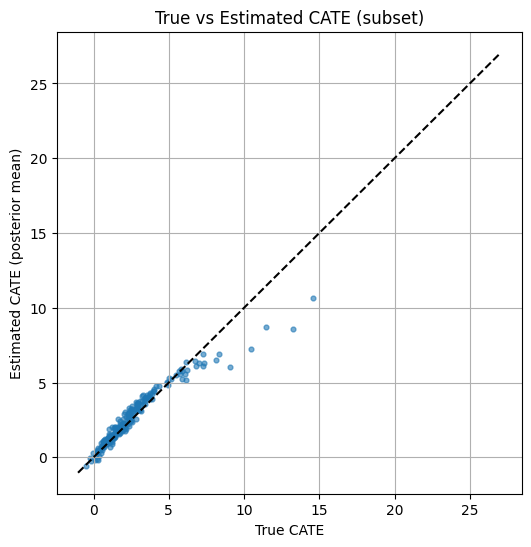

RMSE on CATE estimate: 0.877
To inspect per-feature contributions precisely, generate sampled_module = pyro.random_module(...)() with parameters drawn from the guide and call sampled_module(X, t).


In [5]:

# Plot true vs estimated CATE (random subset)
import numpy as np
idx = np.random.choice(N, size=200, replace=False)
plt.figure(figsize=(6,6))
plt.scatter(tau_true_np[idx], cate_mean[idx], alpha=0.6, s=12)
plt.plot([tau_true_np.min()-0.5, tau_true_np.max()+0.5],
         [tau_true_np.min()-0.5, tau_true_np.max()+0.5],
         color="k", linestyle="--")
plt.xlabel("True CATE")
plt.ylabel("Estimated CATE (posterior mean)")
plt.title("True vs Estimated CATE (subset)")
plt.grid(True)
plt.show()

# Quick metrics
mse = ((cate_mean - tau_true_np)**2).mean()
print(f"RMSE on CATE estimate: {np.sqrt(mse):.3f}")

# -----------------------------
# 6) How to inspect per-feature learned contributions (interpretability)
# -----------------------------
# A: sample modules from the guide and compute the subnet outputs to get per-feature contributions.
from pyro.infer import Predictive as PredictiveGuide

# draw samples of the Bayesian module by sampling latent params from the guide
# We'll call the underlying deterministic network by setting t to 1 and 0 and compute per-feature outputs
S = 50
samples = guide.get_posterior().sample((S,))  # dictionary of latent param draws

# helper to load sampled params into det_model-like structure is nontrivial here,
# but we can instead reuse Predictive to get obs and then approximate per-feature contributions:
# If you need exact per-feature module outputs, use pyro.random_module sampling directly: see next snippet.

print("To inspect per-feature contributions precisely, generate sampled_module = pyro.random_module(...)() with parameters drawn from the guide and call sampled_module(X, t).")

# (End)
